## Importing libraries

In [47]:
import pandas as pd
import random
import json
import matplotlib.pyplot as plt
from tqdm import tqdm, tnrange, tqdm_notebook
import pickle

## Data and Setting
### Multiple category to single category for the articles

In this part, `wiki-topcats-categories.txt` file will be read to attach only one category to one article. Selection will be uniformly random for the categories. 
The new file containing this change will be named as `wiki-topcats-categories-new.txt` .

In [5]:
list_of_pages_per_categ = open("wiki-topcats-categories.txt", "r")
# categ_to_page dictionary consists categories as keys, article number as values.
categ_to_page = {}
a = list_of_pages_per_categ.readline()
while a != '':
    a = a.split()
    categ_to_page[a[0]] = a[1:]
    a = list_of_pages_per_categ.readline()

In [6]:
# page_to_single_category dictionary is created to see all existing categories for each articles
# while keys contain article number, values contain corresponding categorie(s) for the key
page_to_single_category = {} 
for i in categ_to_page.keys():
    for j in range(len(categ_to_page[i])):
        if categ_to_page[i][j] in page_to_single_category: 
            page_to_single_category[categ_to_page[i][j]].append(i) 
        else: 
            page_to_single_category[categ_to_page[i][j]]=[i] 

# generating a uniform random sampling from values for each key
for i in page_to_single_category.keys():
    page_to_single_category[i] = random.choice(page_to_single_category[i])

In [7]:
# creating a dictionary to match categories(key) to articles(value)
# This is known as swapping key and value in python dictionaries
new_categ_to_page = {} 
for key, value in page_to_single_category.items(): 
    if value in new_categ_to_page: 
        new_categ_to_page[value].append(key) 
    else: 
        new_categ_to_page[value]=[key] 

In [8]:
# writing a new version of `wiki-topcats-categories.txt` in a file
with open('wiki-topcats-categories-new.txt', 'w') as file:
    for i in new_categ_to_page.keys():
        my_str = i+' '+ " ".join(new_categ_to_page[i])
        file.write(my_str)
        file.write("\n")

In [9]:
page_names = open("wiki-topcats-page-names.txt", "r")
print(page_names.readline())

0 Chiasmal syndrome



In [10]:
reduced = pd.read_csv('wikigraph_reduced.csv', sep='\t').rename(
    columns = {'Unnamed: 0' : 'edge', '0' : 'source', '1' : 'target'} )

In [11]:
reduced

,edge,source,target
0,796,95,1185516
1,909,108,1059989
2,910,108,1062426
3,911,108,1161925
4,1141,134,541222
...,...,...,...
483089,28511768,1791481,1060990
483090,28511769,1791481,1061382
483091,28511771,1791481,1110380
483092,28511772,1791482,80740


In [12]:
page_names = open("wiki-topcats-page-names.txt", "r")
page_names.readline()

'0 Chiasmal syndrome\n'

## RQ1
### Build the graph G=(V, E), where V is the set of articles and E the hyperlinks among them. Then, provide its basic information:


In [36]:
def graph(reduced_df):
    
    edges = [(reduced.iloc[i].source, reduced.iloc[i].target) for i in range(len(reduced))]
    vertices = list(set(list(reduced.source) + list(reduced.target)))
    
    return edges, vertices

### Is the graph directed?

In [14]:
def directed(reduced_df):
    
    keep = 0
    for i in range(len(reduced_df)):
        if  (reduced_df.iloc[i].source in reduced_df.target and reduced_df.iloc[i].target in reduced_df.source):
            keep += 1
            
    if keep == len(reduced_df):
        
        return False
    
    else:
        
        return True            

In [15]:
if directed(reduced) == True:
    print("The graph is directed.")
else:
        print("The graph is not directed.")

The graph is directed.


### How many articles are we considering?

In [16]:
e, v = graph(reduced)

In [17]:
print("There are totally " + str(len(v)) + " articles.")

There are totally 98343 articles.


### How many hyperlinks between pages exist?

In [18]:
print("There are " + str(len(reduced)) + " hyperlinks.")

There are 483094 hyperlinks.


### Compute the average number of links in an arbitrary page. What is the graph density? Do you believe that the graph is dense or sparse? Is the graph dense?

In [16]:
# k = number of arbitrary page(s) to be chosen
def avg_number_of_links(k, reduced_df):
    my_sample = reduced_df.sample(k)
    total = 0
    for i in range(k):
        total += len(reduced_df[reduced_df.target == my_sample.iloc[i].source])
    average = total/k
    return average

In [17]:
avg_number_of_links(4, reduced)

42.25

In [18]:
def graph_density(reduced_df):
    e, v = graph(reduced_df)
    if directed(reduced_df):
        D = len(e)/(len(v)*(len(v)-1))
    else:
        D = 2 * len(e)/(len(v)*(len(v)-1))
    return round(D, 3)

In [19]:
print(graph_density(reduced))

0.0


According to result that is created by `graph_density` function, the graph is found sparse.

### Visualize the nodes' degree distribution

In [20]:
def degree_dist_plot(reduced_df):
    e, v = graph(reduced_df)
    degrees = [ len(reduced_df[reduced_df.source == i] ) + len(reduced_df[reduced_df.target == i])  for i in v]
    plt.hist(degrees)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Degree (log-scale)")
    plt.ylabel("Number of nodes (log-scale)")
    plt.title("Degree Distribution")
    plt.show()    

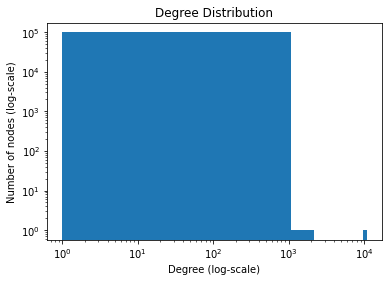

In [21]:
degree_dist_plot(reduced)

# RQ4

## Given in input two categories: C1 and C2, we get the subgraph induced by all the articles in the two categories.

In [28]:
def getInducedGraphBy(c1,c2):
    
    newCategoriesPointer = open("wiki-topcats-categories-new.txt", "r")
    newCategoriesLine = newCategoriesPointer.readline()
    counter = 0
    c1Articles = {}
    c2Articles = {}
    edges = []
    vertices = set()
    
    while newCategoriesLine != '' and counter != 2:
        catName = newCategoriesLine.split()[0].split(":")[1].split(";")[0]
        if catName == c1 :
            counter+=1
            c1Articles = set(newCategoriesLine.split()[1:])
        elif catName == c2:
            counter+=1
            c2Articles = set(newCategoriesLine.split()[1:])
        newCategoriesLine = newCategoriesPointer.readline()
    
    for i in range(len(reduced)):
        source = str(reduced.iloc[i].source)
        target = str(reduced.iloc[i].target)
        if source in c1Articles or source in c2Articles :
            if target in c1Articles or target in c2Articles :
                edges.append((reduced.iloc[i].source, reduced.iloc[i].target))
                vertices.add(reduced.iloc[i].source)
                vertices.add(reduced.iloc[i].target)
                
    vertices = list(vertices)
    return edges, vertices

In [20]:
edge , graph = getInducedGraphBy("Buprestoidea","People_from_Worcester")

#edge = [(1,3),(1,5),(3,5),(2,3),(5,4),(4,6),(2,6)]

print(edge)

[(538870, 540020), (540020, 538870)]


## Let v and u two arbitrary pages in the subgraph. What is the minimum set of hyperlinks one can remove to disconnect u and v?

In [22]:
def deleteEdge(graph , start , end):
    list = graph[start]
    list.remove(end)


def bfs(graph , start):
    parentMap = {}
    visited = []
    
    queue = []
    qStartIndex = 0
    parentMap[start] = -1
    queue.append(start)
    
    while qStartIndex < len(queue):
        curr = queue[qStartIndex]
        qStartIndex+=1
        visited.append(curr)
        for k in graph[curr]:
            if k not in visited:
                queue.append(k)
                if k not in parentMap:
                    parentMap[k] = curr
    return parentMap

In [23]:
def minEdgesToDel(input1 , start , end):
    n = len(input1)
    graph = {}
    for i in range(n):
        n1 , n2 = input1[i]
        li = []
        
        if n1 in graph:
            li = graph[n1]
        else:
            li = []
        
        li.append(n2)
        graph[n1] = li
        if n2 in graph:
            li = graph[n2]
        else:
            li = []
        li.append(n1)
        graph[n2] = li
        #print(graph)
    
    minEdgeDeleteCount = 0
    while True:
        parentMap = bfs(graph , start)
        
        if end in parentMap:
            minEdgeDeleteCount += 1
            parent = parentMap[end]
            currEnd = end
            while parent != -1:
                deleteEdge(graph,parent,currEnd)
                currEnd = parent
                parent = parentMap[currEnd]
        else:
            break
    
    return minEdgeDeleteCount

In [24]:
print(edge)
#print(graph)

minEdgesToDel(edge, 538870 , 540020)

[(538870, 540020), (540020, 538870)]


2

# RQ5

## Write a function that, given an arbitrary category C0 as input, returns the list of remaning categories sorted by their distance from C0. In particular, the distance between two categories is defined as 

## distance(C0, Ci) = median(ShortestPath(C0, Ci))

## where ShortestPath(C0, Ci) is the set of shortest paths from each pair of nodes in the two categories

In [31]:
with open("wiki-topcats-categories-new.txt", "r") as f2:
    categories = {} # {category0 : [article1, article2, ...], ...., 5: [23, 45, 6]}
    categories_names = {} # {category_name : index, ...}
    categories_names_by_index = {}
    for cat_indx, line in enumerate(f2.readlines()):
        line_content = line.split(";")
        categories[cat_indx] = list(map(int, line_content[1].split()))
        categories_names[line_content[0].split(":")[1]] = cat_indx
        categories_names_by_index[cat_indx] = line_content[0].split(":")[1]
        

In [34]:
C0_name = input("Please, choose the name of category: \n\n")
C0_idx = categories_names[C0_name]
print("The index of selected category: ", C0_idx)

tmp_selected_category_indx = []
# filtering categories with nodes more than 3500
for i in range(len(categories)):
    if len(categories[i]) > 3500:
        tmp_selected_category_indx.append(i)

Please, choose the name of category: 

Buprestoidea
The index of selected category:  0


In [38]:
grouped_categories_nodes = [] # nodes grouped per category -- without C0 category
categories_nodes = set() # all nodes together -- without C0 category

e, v = graph(reduced)

# chose the category C0 with nodes only included in the DG graph:
C0 = set(categories[C0_idx]).intersection(v)



final_selected_category_indx = []
# chose categories with nodes only included in the DG graph:
for idx in tmp_selected_category_indx[1:]:
    tmp_categ = set(categories[idx]).intersection(v)
    # if C_i contains different nodes than C0:
    C_i = tmp_categ - C0
    if len(C_i) != 0 and len(C_i) < 100000:
        final_selected_category_indx.append(idx)
        grouped_categories_nodes.append(C_i)
        categories_nodes = categories_nodes.union(C_i)

In [39]:
len(grouped_categories_nodes)

4

In [40]:
len(C0)

0

### Shortest Path func

In [41]:
def bfs_shortest_path(graph, start, categories_nodes):
    visited_dict = defaultdict(lambda:[False])
    queue = [start]
    visited_dict[start] = 0
    
    while queue:
        node = queue.pop(0)
        distance = visited_dict[node]
        try:
            for neighbour in graph.neighbors(node):
                if visited_dict[neighbour]==[False]:
                    visited_dict[neighbour] = distance + 1
                    queue.append(neighbour)
        except KeyError: pass
    return {node:visited_dict[node] for node in categories_nodes}

## RQ6

Write a function that sorts the categories in the graph according to their PageRank (PR). For this task you need to model the network of categories such that you can apply the PR algorithm.

The following function is very crucial to solve this question. There are 2 dictionaries that are created. `inlink_dict` provides the nodes(keys), and node's inlink elements(values), just the opposite `outlink_dict` consists the nodes(keys), and node's outlink elements(values). 

In [22]:
def extensive_dict(reduced, v):
    inlink_dict = {}
    for i in v:
        inlink_dict[i] = list(reduced[reduced.target == i].source)
    outlink_dict = {}
    for i in v:
        outlink_dict[i] = list(reduced[reduced.source == i].target)
    return inlink_dict, outlink_dict

In [23]:
i_d, o_d = extensive_dict(reduced, v)

In the following, `pagerank` function takes vertices, 'inlink_dict, outlink_dict', created by `extensive_dict` function, and number_of_iter, given by user, to find pagerank values for each page that exist in `reduced` dataframe. The function returns `pagerank_dict` dictionary which has keys as pages, and values as pagerank value of the corresponding link.

In [24]:
def pagerank(v, inlink_dict, outlink_dict, number_of_iter):
    pagerank_dict = {}
    n = len(v)
    for i in v:
        pagerank_dict[i] = 1/n
    
    for iter in tqdm(range(number_of_iter)):
        new_pagerank_dict = {}
        for i in pagerank_dict.keys():
            new_pagerank_dict[i] = 0

        for i in pagerank_dict.keys():
            inlink_list = inlink_dict[i]

            for j in inlink_list:
                new_pagerank_dict[i] += pagerank_dict[j]/len(outlink_dict[j])

        pagerank_dict = new_pagerank_dict.copy()
        
    return pagerank_dict
    

In [25]:
p_d =pagerank(v, i_d , o_d, 500)

100%|██████████| 500/500 [02:09<00:00,  3.87it/s]


Next code stores the total value of the pagerank for each categories. `new_categ_to_page` dictionary which is created in the first question is given as input. Another input of that function is pagerank_dict which is the output of the `pagerank` function.  

In [26]:
def sort_categ_by_pagerank(new_categ_to_page, pagerank_dict):
    pagerank_sort = {}
    for categ in new_categ_to_page.keys():
        pages_in_categ = new_categ_to_page[categ]
        total_score =0
        for page in pages_in_categ:
            if int(page) in pagerank_dict.keys():
                total_score += pagerank_dict[int(page)]
        pagerank_sort[categ] = total_score
    pagerank_sort = {x: y for x, y in sorted(pagerank_sort.items(), key = lambda item: item[1])}
    return pagerank_sort

In [27]:
s_c_b_p = sort_categ_by_pagerank(new_categ_to_page, p_d)